<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: 
* Reward function: 
* State: 
* Environment: 

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages

In [1]:
!pip install -r requirements.txt --user

  Running command git clone -q git://github.com/dvdpedros/pyfolio 'C:\Users\elena.bonan\AppData\Local\Temp\pip-req-build-y0fckg5i'
  Running command git checkout -b fix-extreme-drawdown --track origin/fix-extreme-drawdown
  Branch 'fix-extreme-drawdown' set up to track remote branch 'fix-extreme-drawdown' from 'origin'.
  Switched to a new branch 'fix-extreme-drawdown'


  Cloning git://github.com/dvdpedros/pyfolio (to revision fix-extreme-drawdown) to c:\users\elena.bonan\appdata\local\temp\pip-req-build-y0fckg5i


<a id='1.2'></a>
## 2.2. Import Packages

In [2]:
%load_ext autoreload
%autoreload 
import pandas as pd
from config import config
from dataset.download_dataset.cryptodownloader_binance import CryptoDownloader_binance
from preprocessing.preprocessors import FeatureEngineer
from preprocessing.data import data_split
from env.env_custom import CustomTradingEnv
from model.models import DRLAgent
from trade.backtest import BackTest
import warnings
warnings.filterwarnings("ignore")



C:\Users\elena.bonan\AppData\Roaming\Python\Python37\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.3'></a>
## 2.3 Create Folders

In [3]:
import os
download_data = False
if not os.path.exists(config.DATA_SAVE_DIR):
    os.makedirs(config.DATA_SAVE_DIR)
    download_data = True
if not os.path.exists(config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists(config.TENSORBOARD_LOG_DIR):
    os.makedirs(config.TENSORBOARD_LOG_DIR)
if not os.path.exists(config.RESULTS_DIR):
    os.makedirs(config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data

In [4]:
data_downloader = CryptoDownloader_binance(config.START_DATE, config.END_DATE, config.MULTIPLE_TICKER_8, config.DATA_SAVE_DIR, config.DATA_GRANULARITY)
if download_data:    
    data_downloader.download_data()
df = data_downloader.load()

In [5]:
df

date     open     high      low    close        volume  \
0      2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02    511.814901   
1      2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27    883.052603   
2      2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85    655.156809   
3      2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01    783.724867   
4      2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27    467.812578   
...                    ...      ...      ...      ...      ...           ...   
99259  2021-05-31 19:00:00   181.99   183.70   181.24   183.63  25486.024430   
99260  2021-05-31 20:00:00   183.64   184.20   181.64   182.22  22064.516800   
99261  2021-05-31 21:00:00   182.22   184.09   182.12   183.82  17366.167650   
99262  2021-05-31 22:00:00   183.80   185.92   183.35   183.83  37268.340650   
99263  2021-05-31 23:00:00   183.85   188.50   183.54   187.97  44042.666530   

       tic  
0      btc  
1      btc  
2      btc  
3      btc  
4      btc  
...    ...  
99259  ltc  
99260  ltc  
99261  ltc  
99262  ltc  
99263  ltc  

[99264 rows x 7 columns]

# Part 4: Preprocess Data

In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True,
                    use_covariance= True
)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [7]:
df.head()

date         open         high          low       close  \
0  2020-01-31 00:00:00     0.056140     0.056800     0.055900     0.05624   
1  2020-01-31 00:00:00    18.555700    18.688400    18.494200    18.49960   
2  2020-01-31 00:00:00  9511.520000  9530.220000  9472.860000  9473.87000   
3  2020-01-31 00:00:00     0.002416     0.002445     0.002416     0.00243   
4  2020-01-31 00:00:00   184.710000   185.820000   183.710000   184.08000   

         volume   tic  psar        ui        atr  ...   cov_6_6   cov_6_7  \
0  1.831878e+07   ada   0.0  1.165902   0.000965  ...  0.000101  0.000056   
1  9.697471e+04   bnb   0.0  0.450293   0.180644  ...  0.000101  0.000056   
2  1.168793e+03   btc   0.0  0.392346  80.617589  ...  0.000101  0.000056   
3  3.396466e+06  doge   0.0  0.229820   0.000019  ...  0.000101  0.000056   
4  1.352616e+04   eth   0.0  0.522519   2.294014  ...  0.000101  0.000056   

    cov_7_0   cov_7_1  cov_7_2   cov_7_3   cov_7_4   cov_7_5   cov_7_6  \
0  0.000048  0.000042  0.00003  0.000024  0.000043  0.000041  0.000056   
1  0.000048  0.000042  0.00003  0.000024  0.000043  0.000041  0.000056   
2  0.000048  0.000042  0.00003  0.000024  0.000043  0.000041  0.000056   
3  0.000048  0.000042  0.00003  0.000024  0.000043  0.000041  0.000056   
4  0.000048  0.000042  0.00003  0.000024  0.000043  0.000041  0.000056   

    cov_7_7  
0  0.000061  
1  0.000061  
2  0.000061  
3  0.000061  
4  0.000061  

[5 rows x 135 columns]

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2020-02-02 to 2020-12-31

In [8]:
train = data_split(df, '2020-02-02','2020-12-31')

## Environment for Portfolio Allocation


In [9]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
features =  config.TECHNICAL_INDICATORS_SHORTPERIOD + config.TECHNICAL_INDICATORS_LONGPERIOD  + ["open", "close", 'high', 'low']
features += [f"{feature}_diff" for feature in features]
features += [feature for feature in features if feature.startswith("cov_")]

env_kwargs = {
    "initial_amount": 1000000, 
    "technical_indicator_list": features, 
    "max_assets_amount_per_trade": 100, 
    "main_tickers": train.tic.unique(),
    "all_tickers": train.tic.unique(),
    "reward_scaling": 1e-4,
    "comission_value": 0.01
    
}

e_train_gym = CustomTradingEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()

Stock Dimension: 8, State Space: 8


<a id='5'></a>
# Part 6: Implement DRL Algorithms

In [10]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [11]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS, tensorboard_log = config.TENSORBOARD_LOG_DIR)

Using cpu device


In [12]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=100)

Logging to ./tensorboard_log_from_main\a2c_1


### Model 2: **PPO**

In [ ]:
# agent = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.005,
#     "learning_rate": 0.0001,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
# trained_ppo = agent.train_model(model=model_ppo, 
#                              tb_log_name='ppo',
#                              total_timesteps=80000)

## Trading
Assume that we have $1,000,000 initial capital at 2021-01-01.

In [14]:
trade = data_split(df,config.START_TEST_DATE, config.END_DATE)
e_trade_gym = CustomTradingEnv(df = trade, **env_kwargs)

In [15]:
trade.shape

(28992, 135)

In [16]:
trade

date          open          high           low  \
0     2021-01-01 00:00:00      0.181340      0.181460      0.178310   
0     2021-01-01 00:00:00     37.359600     37.442300     36.963600   
0     2021-01-01 00:00:00  28923.630000  29031.340000  28690.170000   
0     2021-01-01 00:00:00      0.004672      0.004701      0.004601   
0     2021-01-01 00:00:00    736.420000    739.000000    729.330000   
...                   ...           ...           ...           ...   
3623  2021-05-31 23:00:00      0.324120      0.328000      0.323720   
3623  2021-05-31 23:00:00   2644.810000   2720.000000   2639.200000   
3623  2021-05-31 23:00:00     30.883000     32.159000     30.757000   
3623  2021-05-31 23:00:00    183.850000    188.500000    183.540000   
3623  2021-05-31 23:00:00      1.009900      1.049500      1.008800   

             close        volume   tic  psar        ui         atr  ...  \
0         0.180510  1.919492e+07   ada   0.0  3.174316    0.003072  ...   
0        37.376400  9.511383e+04   bnb   1.0  2.328882    0.404216  ...   
0     28995.130000  2.311811e+03   btc   0.0  1.505422  378.624288  ...   
0         0.004679  2.768207e+07  doge   0.0  2.016111    0.000074  ...   
0       734.070000  2.793270e+04   eth   0.0  1.998452    9.626878  ...   
...            ...           ...   ...   ...       ...         ...  ...   
3623      0.325570  6.227246e+07  doge   0.0  0.742394    0.005856  ...   
3623   2706.150000  5.189105e+04   eth   0.0  0.741262   56.493247  ...   
3623     32.098000  5.569937e+05  link   0.0  0.872105    0.918285  ...   
3623    187.970000  4.404267e+04   ltc   0.0  0.905923    3.672284  ...   
3623      1.040900  4.944775e+07   xrp   1.0  2.280649    0.024941  ...   

       cov_6_6   cov_6_7   cov_7_0   cov_7_1   cov_7_2   cov_7_3   cov_7_4  \
0     0.000192  0.000188  0.000151  0.000090  0.000080  0.000135  0.000112   
0     0.000192  0.000188  0.000151  0.000090  0.000080  0.000135  0.000112   
0     0.000192  0.000188  0.000151  0.000090  0.000080  0.000135  0.000112   
0     0.000192  0.000188  0.000151  0.000090  0.000080  0.000135  0.000112   
0     0.000192  0.000188  0.000151  0.000090  0.000080  0.000135  0.000112   
...        ...       ...       ...       ...       ...       ...       ...   
3623  0.000553  0.000432  0.000427  0.000396  0.000247  0.000410  0.000369   
3623  0.000553  0.000432  0.000427  0.000396  0.000247  0.000410  0.000369   
3623  0.000553  0.000432  0.000427  0.000396  0.000247  0.000410  0.000369   
3623  0.000553  0.000432  0.000427  0.000396  0.000247  0.000410  0.000369   
3623  0.000553  0.000432  0.000427  0.000396  0.000247  0.000410  0.000369   

       cov_7_5   cov_7_6   cov_7_7  
0     0.000160  0.000188  0.000682  
0     0.000160  0.000188  0.000682  
0     0.000160  0.000188  0.000682  
0     0.000160  0.000188  0.000682  
0     0.000160  0.000188  0.000682  
...        ...       ...       ...  
3623  0.000471  0.000432  0.000513  
3623  0.000471  0.000432  0.000513  
3623  0.000471  0.000432  0.000513  
3623  0.000471  0.000432  0.000513  
3623  0.000471  0.000432  0.000513  

[28992 rows x 135 columns]

In [17]:
allocations, transactions, allocation_values = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [18]:
allocations

cash         ada         bnb   btc        doge        eth  \
0   996191.156758   62.766176  100.000000   0.0    0.000000   0.000000   
0   960730.173056  117.795640   18.822002   0.0   81.622511  50.922483   
0   995649.970226   17.795640   55.905584   0.0  155.399162   0.000000   
0   962170.819762   96.422964   95.721471   0.0  237.469131  25.343210   
0       91.406114  196.422964  195.721471  32.0  293.957990  43.343210   
..            ...         ...         ...   ...         ...        ...   
0        0.680758    0.000000    0.000000   0.0    0.000000   0.000000   
0        0.680758    0.000000    0.000000   0.0    0.000000   0.000000   
0        0.044337    0.000000    0.000000   0.0    2.000000   0.000000   
0        0.680550    0.000000    0.000000   0.0    0.000000   0.000000   
0        0.680550    0.000000    0.000000   0.0    0.000000   0.000000   

          link        ltc         xrp                 date  
0     0.000000   0.000000  100.000000  2021-01-01 01:00:00  
0     0.000000   0.000000   45.474303  2021-01-01 02:00:00  
0   100.000000   0.000000  122.716665  2021-01-01 03:00:00  
0    98.366594  97.013259   88.530317  2021-01-01 04:00:00  
0   129.207086  97.007191   23.137477  2021-01-01 05:00:00  
..         ...        ...         ...                  ...  
0     0.000000   0.000000    0.000000  2021-05-31 17:00:00  
0     0.000000   0.000000    0.000000  2021-05-31 18:00:00  
0     0.000000   0.000000    0.000000  2021-05-31 19:00:00  
0     0.000000   0.000000    0.000000  2021-05-31 20:00:00  
0     0.000000   0.000000    0.000000  2021-05-31 21:00:00  

[3621 rows x 10 columns]

In [19]:
transactions

date operation   tic      amount     price
0   2021-01-01 00:00:00       buy   ada   62.766176   0.18051
0   2021-01-01 00:00:00       buy   bnb  100.000000  37.37640
0   2021-01-01 00:00:00       buy   xrp  100.000000   0.22162
0   2021-01-01 01:00:00       buy   ada   55.029464   0.18358
0   2021-01-01 01:00:00      sell   bnb   81.177998  37.61340
..                  ...       ...   ...         ...       ...
0   2021-05-31 13:00:00      sell  doge    2.000000   0.30774
0   2021-05-31 14:00:00       buy  doge    2.000000   0.30820
0   2021-05-31 16:00:00      sell  doge    2.000000   0.31484
0   2021-05-31 18:00:00       buy  doge    2.000000   0.31506
0   2021-05-31 19:00:00      sell  doge    2.000000   0.32132

[14565 rows x 5 columns]

In [20]:
allocation_values

cash        ada          bnb        btc      doge           eth  \
0   996191.156758  11.522615  3761.340000       0.00  0.000000      0.000000   
0   960730.173056  21.636703   714.483212       0.00  0.388123  37889.382854   
0   995649.970226   3.255179  2120.219254       0.00  0.773593      0.000000   
0   962170.819762  17.529695  3624.991263       0.00  1.162126  18812.010984   
0       91.406114  35.939510  7381.224275  933984.32  1.452711  32102.148120   
..            ...        ...          ...        ...       ...           ...   
0        0.680758   0.000000     0.000000       0.00  0.000000      0.000000   
0        0.680758   0.000000     0.000000       0.00  0.000000      0.000000   
0        0.044337   0.000000     0.000000       0.00  0.642640      0.000000   
0        0.680550   0.000000     0.000000       0.00  0.000000      0.000000   
0        0.680550   0.000000     0.000000       0.00  0.000000      0.000000   

           link           ltc        xrp                 date  
0      0.000000      0.000000  22.382000  2021-01-01 01:00:00  
0      0.000000      0.000000  10.168509  2021-01-01 02:00:00  
0   1150.060000      0.000000  27.893498  2021-01-01 03:00:00  
0   1127.035246  12696.125197  21.156975  2021-01-01 04:00:00  
0   1478.529604  12696.301182   5.511116  2021-01-01 05:00:00  
..          ...           ...        ...                  ...  
0      0.000000      0.000000   0.000000  2021-05-31 17:00:00  
0      0.000000      0.000000   0.000000  2021-05-31 18:00:00  
0      0.000000      0.000000   0.000000  2021-05-31 19:00:00  
0      0.000000      0.000000   0.000000  2021-05-31 20:00:00  
0      0.000000      0.000000   0.000000  2021-05-31 21:00:00  

[3621 rows x 10 columns]

<a id='6'></a>
# Part 7: Backtest

In [21]:
%load_ext autoreload
%autoreload 
bat = BackTest(trained_a2c, e_trade_gym)
bat.create_summary(allocations, allocation_values, transactions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


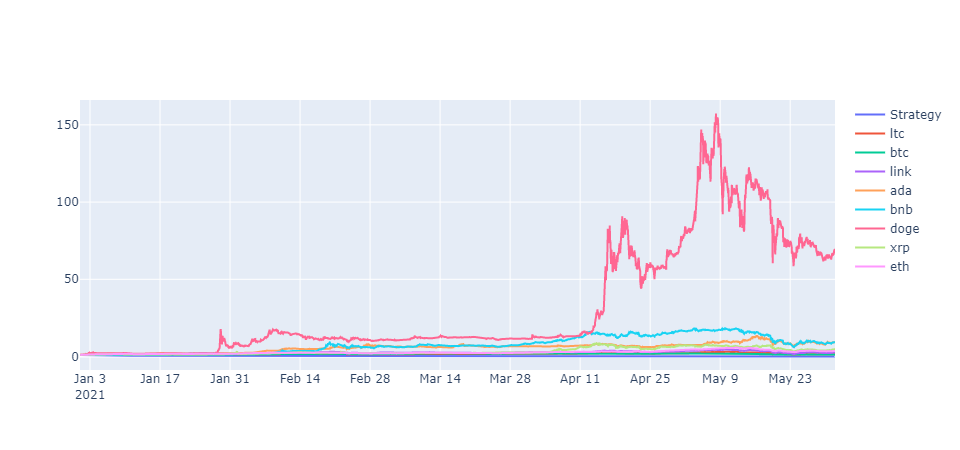

In [22]:
bat.plot_return_against_hold(allocation_values)

In [23]:
%load_ext autoreload
%autoreload 
from trade.time_series_validation import TimeSeriesValidation
tsv = TimeSeriesValidation(num_splits=5, total_timesteps_model=1000, with_graphs=False)

model_name = "a2c"
model_params = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}

stock_dimension = len(df.tic.unique())
state_space = stock_dimension
features =  config.TECHNICAL_INDICATORS_SHORTPERIOD + config.TECHNICAL_INDICATORS_LONGPERIOD + ["open", "close", 'high', 'low']
features += [f"{feature}_diff" for feature in features]
features += [feature for feature in features if feature.startswith("cov_")]

env_params = {
    "initial_amount": 1000000, 
    "technical_indicator_list": features, 
    "max_assets_amount_per_trade": 100, 
    "main_tickers": df.tic.unique(),
    "all_tickers": df.tic.unique(),
    "reward_scaling": 1e-4,
    "comission_value": 0.01
    
}


results = tsv.run(df, env_params, model_name, model_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train from [2020-01-31 00:00:00] to [2020-04-13 00:00:00]
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 35       |
|    iterations         | 100      |
|    time_elapsed       | 13       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | -0.105   |
|    std                | 1        |
|    value_loss         | 0.0186   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 37       |
|    iterations         | 200      |
|    time_elapsed       | 26       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss      

In [24]:
results

{'return': -0.8222263894012576,
 'sharpe': -110.16735304107146,
 'sortino': -136.96940630212572,
 'max_drawdown': -0.8224329488983436}